In [8]:
import tensorflow as tf
import helperfun as hf
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import bz2
import requests
import os.path as path
import pickle
%matplotlib inline

In [10]:
# loading natural image dataset, converted from here: http://bethgelab.org/datasets/vanhateren/
def load_data(fname):
    folder = './'
    if not path.isfile(folder + fname):
        # if the data is not available locally, dowload it
        print("Downloading data...")
        r = requests.get("http://www.rmki.kfki.hu/~banmi/textures/" + fname + '.bz2')
        print("Decompressing data...")
        bin_data = bz2.decompress(r.content)
        with open(fname, 'wb') as imgfile:
            imgfile.write(bin_data)

    with open(folder + fname, 'rb') as file:
        data = pickle.load(file)
    return data

natural = load_data('natural_24000_28px.pkl')
whitened = load_data('whitened_64000_24px.pkl')

Decompressing data...


In [ ]:
pca = PCA()
pca.fit(natural)

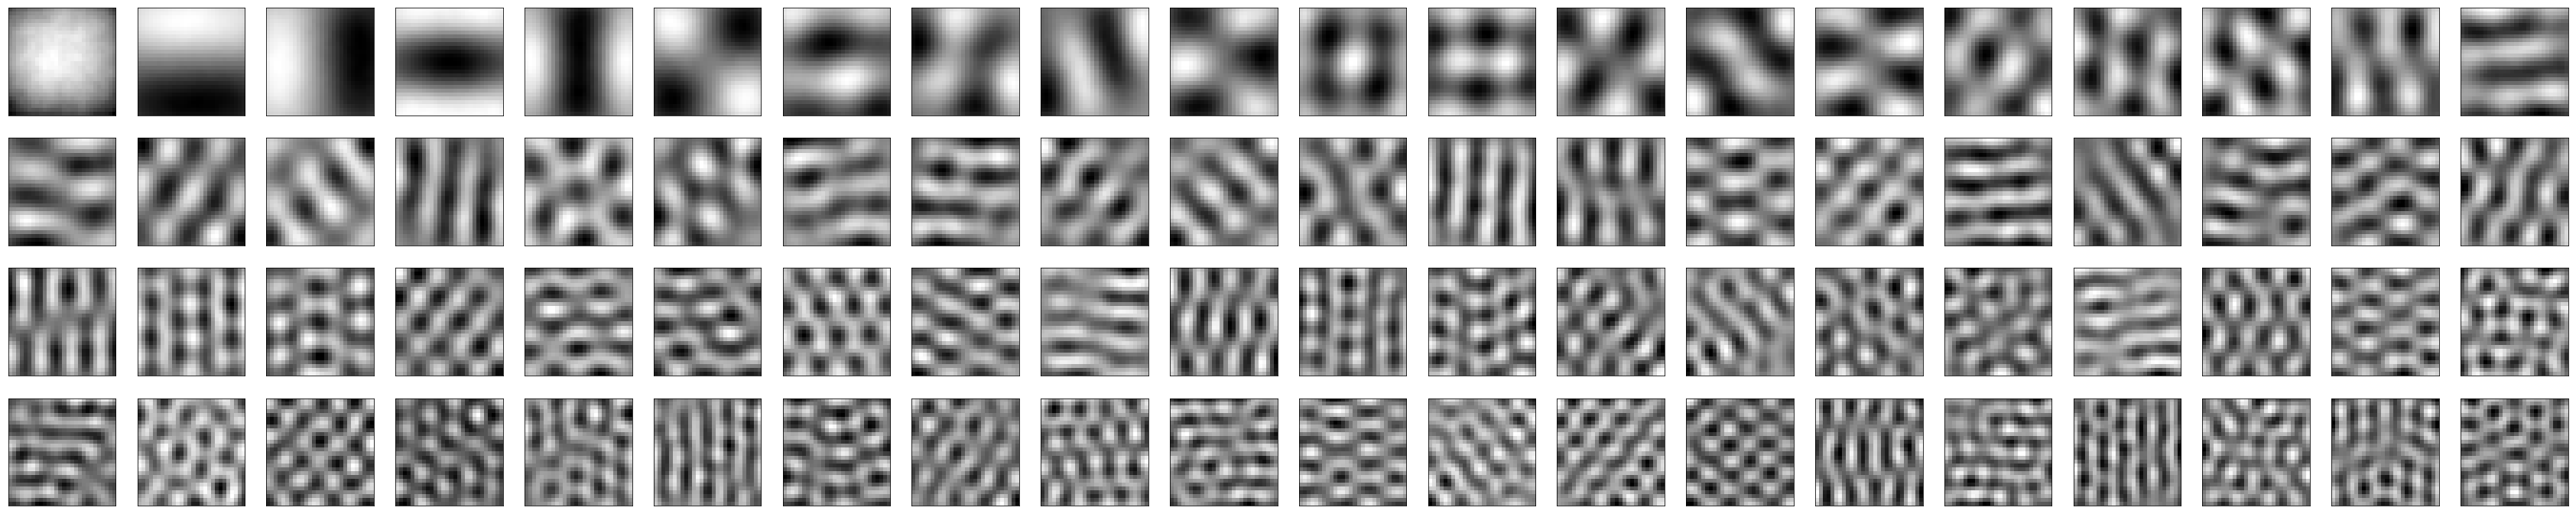

In [21]:
def plot_image_set(images):
    nPX = int(np.sqrt(images.shape[1]))
    samplePerRow = np.minimum(20, images.shape[0])
    nRows = np.ceil(images.shape[0] / samplePerRow)
    f = plt.figure(figsize=(3 * samplePerRow, 3 * nRows))
    for i in range(images.shape[0]):
        plt.subplot(nRows, samplePerRow, i + 1)
        img = images[i, ].reshape(nPX, nPX)
        plt.imshow(img, interpolation='none', cmap=plt.get_cmap('gray'))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
plot_image_set(pca.components_[:80, :])

In [16]:
def OF(data, beta, learningRate, runs, plotComps=None, prior='Laplace'):
    d_x = data.shape[1]
    d_u = int(d_x * 1.5)
    batchSize = 100

    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, shape=[batchSize, d_x])
    # the parameters we want to estimate and their initial values
    AT = tf.Variable(tf.truncated_normal([d_x, d_u], stddev=0.1))
    # how to calculate the hidden quantities we need
    u_map = tf.matmul(x, AT)

    # the negative log-likelihood
    reconstruction_error = tf.reduce_sum((x - tf.matmul(u_map, tf.transpose(AT))) ** 2)
    # the cost component related to the Laplace prior of the hidden variable
    if prior == 'Laplace':
        sparseness_cost = tf.reduce_sum(tf.abs(u_map))
    elif prior == 'Gauss':
        sparseness_cost = tf.reduce_sum(u_map ** 2)
    else:
        raise ValueError('unknown prior')
    # the trade-off factor between the contribution of the prior and the likelihood to the cost
    balance = tf.placeholder(tf.float32,shape=[1])

    cost = reconstruction_error + balance * sparseness_cost

    optimizer =  tf.train.AdamOptimizer(learning_rate=learningRate).minimize(cost)
    sess = tf.InteractiveSession()
    init = tf.global_variables_initializer()
    sess.run(init)
    
    nBatches = int(data.shape[0] / batchSize)

    for epoch in range(runs):    
        for i in range(nBatches):
            batch_xs = data[random.sample(range(data.shape[0]), batchSize), :]
            _, cost_, learnedComponents = sess.run((optimizer, cost, AT), feed_dict={x: batch_xs, balance: beta * np.ones(1)})

        if (epoch + 1) % 10 == 0:
            print("Epoch %d, cost %f" % (epoch + 1, np.mean(cost_)))
            
    sess.close()
    return learnedComponents

In [18]:
learnedComponents = OF(whitened, beta=0.4, learningRate=0.001, runs=60)

Epoch 10, cost 20034.669922
Epoch 20, cost 16549.207031
Epoch 30, cost 16989.609375
Epoch 40, cost 17175.964844
Epoch 50, cost 15868.000000
Epoch 60, cost 15128.533203


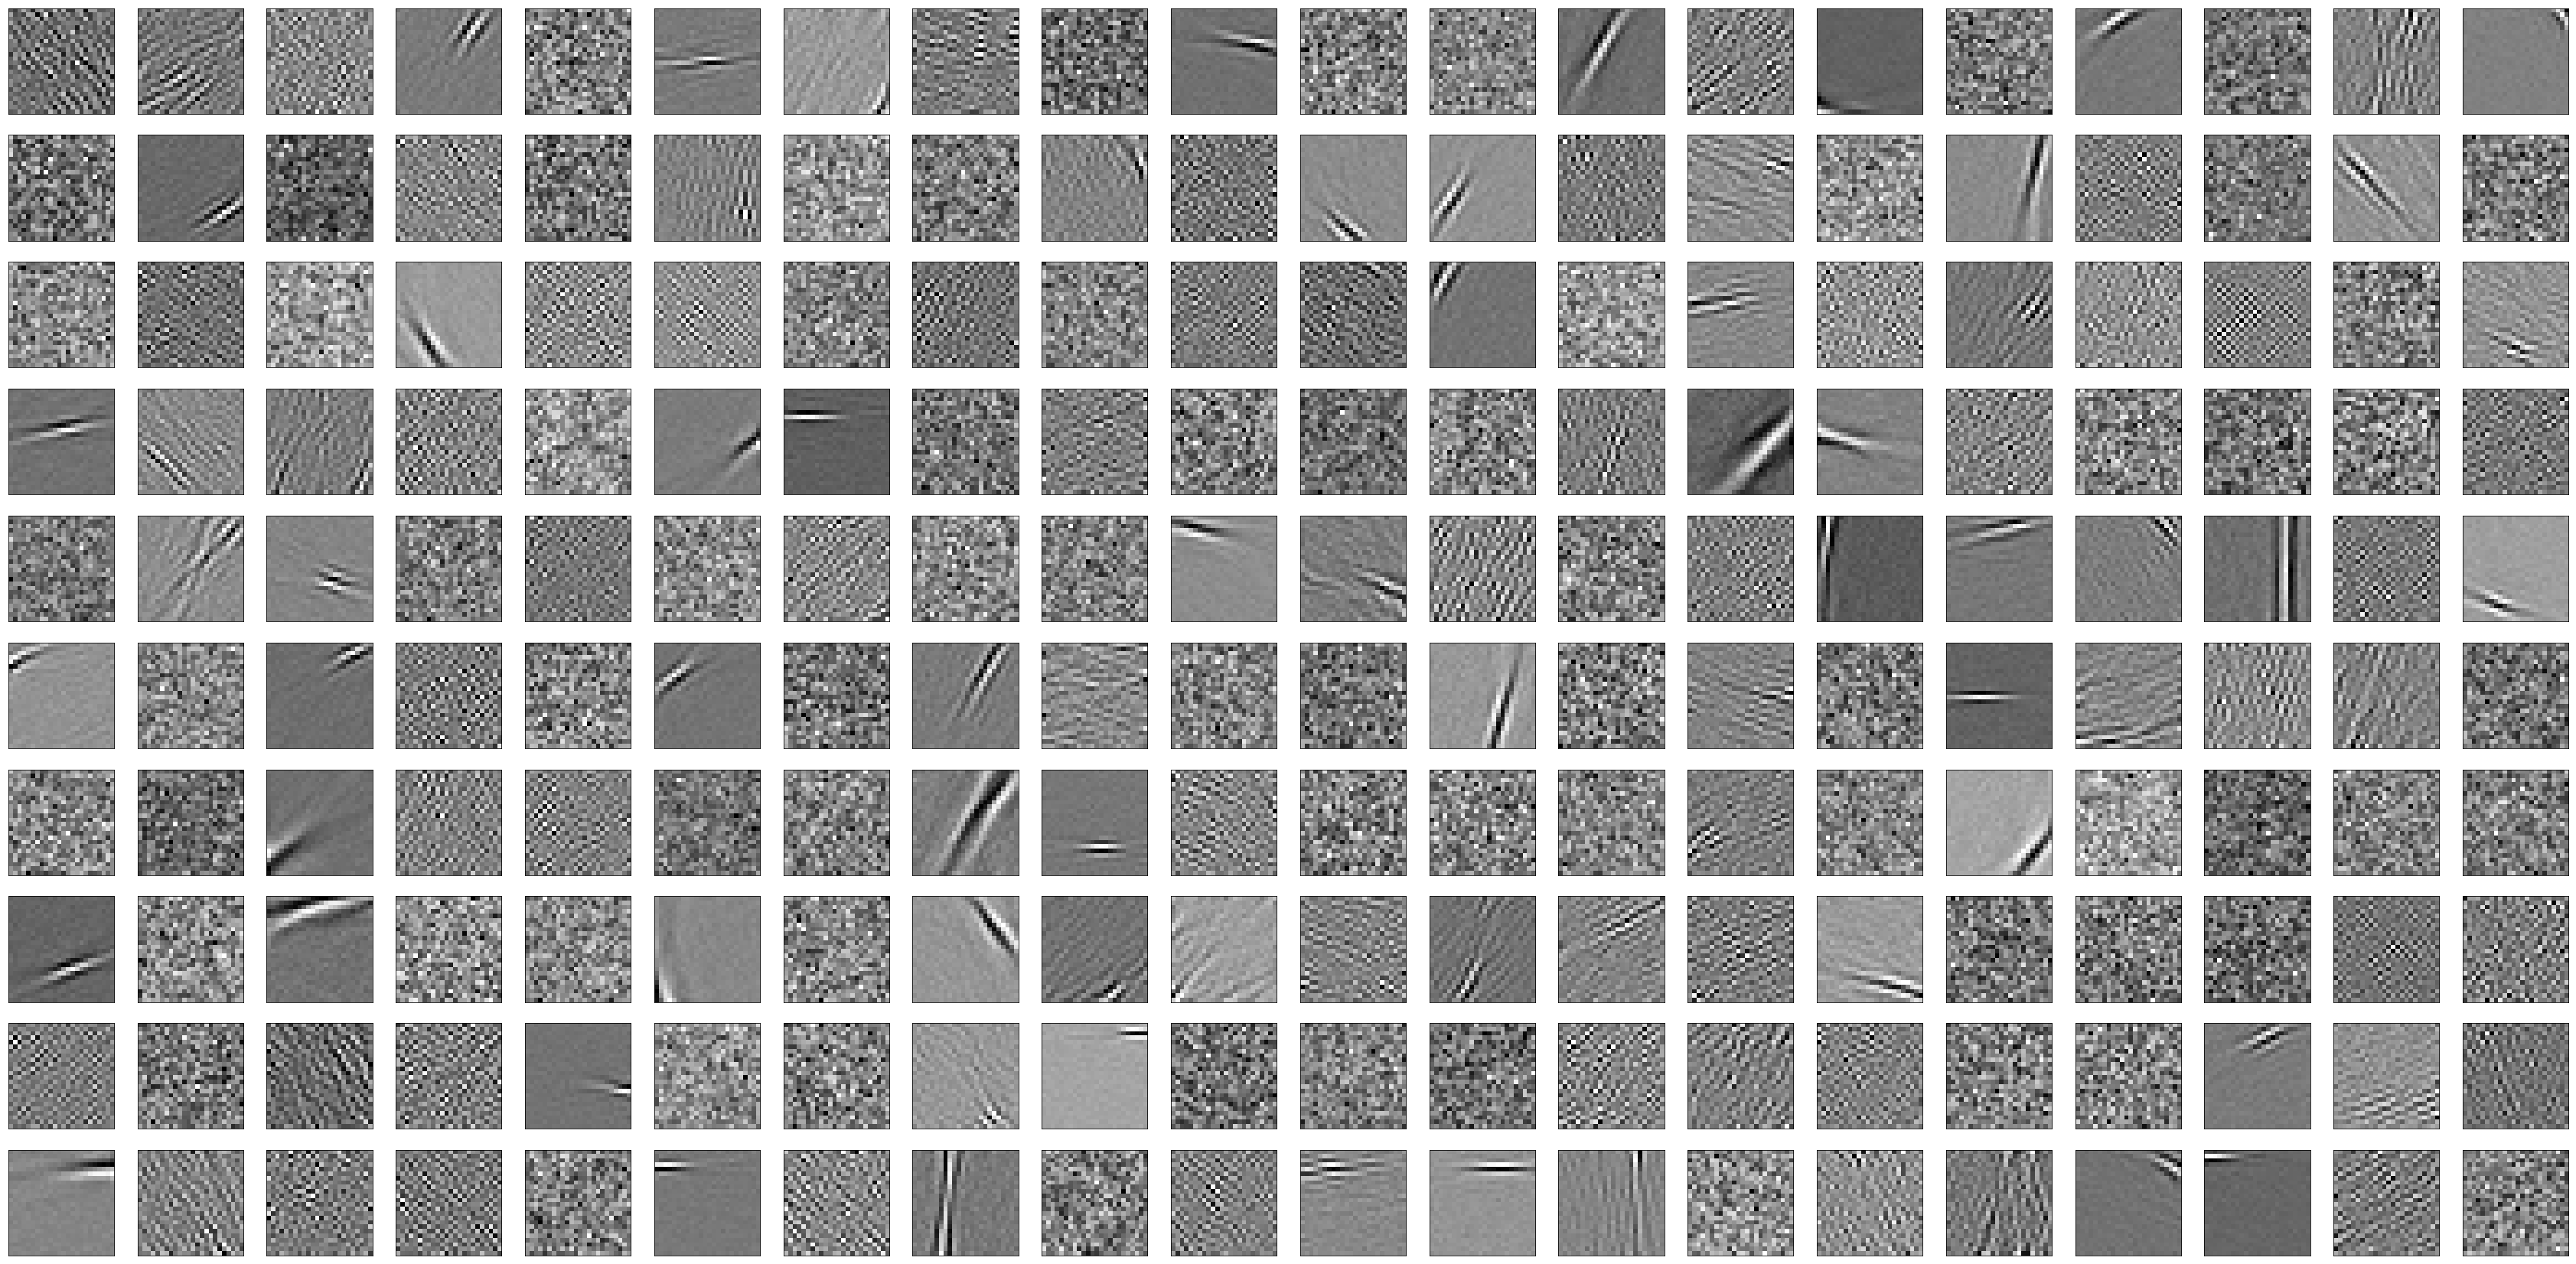

In [22]:
plot_image_set(learnedComponents[:, :200].T)